In [441]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()

22

In [442]:
ProgressMeter.ijulia_behavior(:clear);

In [443]:
# returns a random subset of 1:N, of size p, with no repetitions
function randsubset(n::Int, p::Int, vv=collect(1:N))
    n < p && error("Susbet size cannot be larger than n")
    output = zeros(Int,p)
    for i in 1:p
        r = rand(1:n+1-i)
        output[i] = vv[r]
        vv[r], vv[n+1-i] = vv[n+1-i], vv[r]
    end
    return output
end

function pspinmatrix(n::Int, m::Int, p::Int; vv = collect(1:n))
    H = falses(m, n)
    for f in 1:m
        for v in randsubset(n, p, vv)
            H[f,v] = true
        end
    end
    sparse(H)
end

pspinmatrix (generic function with 1 method)

$\gamma_d=0.818469$

In [444]:
n = 80
γ = 0.75
m = floor(Int, n*γ)
const p = 3
H = pspinmatrix(n, m, p)
B, indep = findbasis_slow(H)
B = BitMatrix(B)
BB = augment_basis(B);

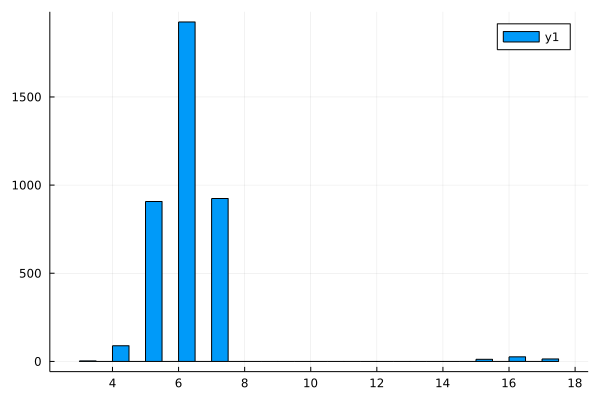

In [445]:
cws = cws_of_weight_w(BB, 22, n)
y = map(count_ones, cws)
histogram(y)

In [446]:
Blight, w = lightest_basis(BB, indep, n)

Finding lightest basis 26 	 Time: 0:00:08
  weight:  26

(Bool[0 0 … 0 1; 0 0 … 0 1; … ; 0 0 … 0 0; 0 0 … 0 0], 28)

In [299]:
h0 = basis_wef(Blight);

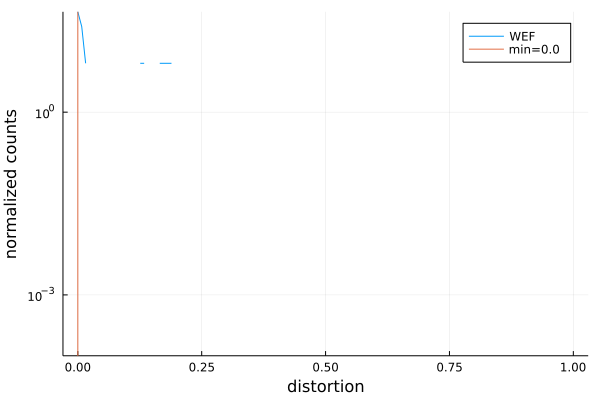

┌ Warning: Invalid negative or zero value 0.0 found at series index 4 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/AJMX6/src/utils.jl:95


In [300]:
plot_wef(h0, yaxis=(:log10, (1e-4,Inf)), st=:line)

### Basis weight as n increases - RS regime

In [ ]:
γ_rs = 0.78
ns_rs = 16 .* (5:7)
nsamples_rs = 500
weights_rs = [zeros(Int, nsamples_rs) for _ in ns_rs]
times_rs = zeros(length(ns_rs))
# save one wef for each sample
wefs_rs = [[Int[] for k in 1:nsamples_rs] for j in eachindex(ns_rs)]
@telegram "xorsat basis RS" for (j,n) in enumerate(ns_rs)
    println("Size n=$n")
    t = @timed begin
        @threads for k in 1:nsamples_rs
            m = floor(Int, n*γ_rs)
            H = pspinmatrix(n, m, p)
            B, indep = findbasis_slow(H)
            B = BitMatrix(B)
            BB = augment_basis(B)
            Blight, weights_rs[j][k] = lightest_basis(BB, indep, n, showprogress=false)
#             wefs_rs[j][k], _, _ = exact_wef(Blight, showprogress=false)
            wefs_rs[j][k] = basis_wef(Blight)
        end
    end
    times_rs[j] = t.time
    flush(stdout)
end

In [344]:
times_rs ./ 3600

3-element Vector{Float64}:
 0.022464682607499998
 0.40834017602722217
 8.406881048421944

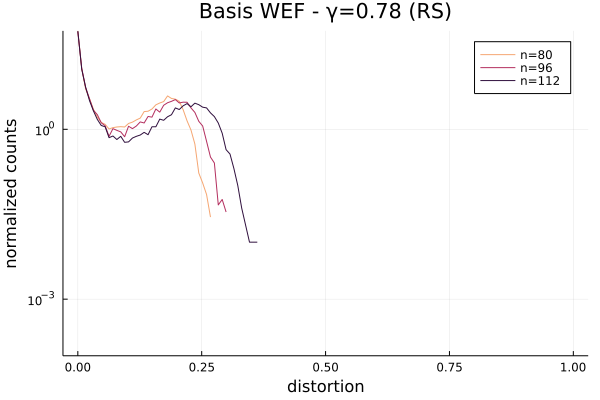

In [458]:
using ColorSchemes
cg = cgrad(:matter, 2*length(ns_rs), categorical=true)
wef_rs = plot()
for (i,n) in enumerate(ns_rs)
#     w = merge_wefs(wefs_rs[i])
    w = sum(wefs_rs[i])
    plot_wef!(wef_rs, w, normalize=true, plotmin=false, st=:line, c=cg[2i], label="n=$n")
end
plot!(wef_rs, title="Basis WEF - γ=$γ_rs (RS)", yaxis=(:log10, (1e-4,Inf)))

In [ ]:
pl_rs = plot(ns_rs, mean.(weights_rs) , err=std.(weights_rs)./sqrt(nsamples_rs), label="γ=$γ_rs (RS)", m=:o,
    xlabel="n", ylabel="weight of lightest basis", legend=:topleft, size=(300,200))

In [ ]:
pl_rs2 = plot(1 ./ns_rs, mean.(weights_rs) ./ ns_rs, label="γ=$γ_rs (RS)", m=:o, 
    yerr=std.(weights_rs)./sqrt(nsamples_rs)./ ns_rs,
    xlabel="1/n", ylabel="weight of lightest basis / n", xlims=(0, 0.1), 
    ylims=(0,0.6))
plot(pl_rs, pl_rs2, size=(800,300))

### Basis weight as n increases - RSB regime

In [ ]:
γ_rsb = 0.85
ns_rsb = 16 .* (7:9)
nsamples_rsb = 500
weights_rsb = [zeros(Int, nsamples_rsb) for _ in ns_rsb]
times_rsb = zeros(length(ns_rsb))
# save one wef for each sample
wefs_rsb = [[Int[] for k in 1:nsamples_rsb] for j in eachindex(ns_rsb)]
@telegram "xorsat basis RSB" for (j,n) in enumerate(ns_rsb)
    println("Size n=$n")
    t = @timed begin
        @threads for k in 1:nsamples_rsb
            m = floor(Int, n*γ_rsb)
            H = pspinmatrix(n, m, p)
            B, indep = findbasis_slow(H)
            B = BitMatrix(B)
            BB = augment_basis(B)
            Blight, weights_rsb[j][k] = lightest_basis(BB, indep, n, showprogress=false)
            Blight_full = [Blight; I]
#             wefs_rsb[j][k], _, _ = exact_wef(Blight_full, showprogress=false)
            wefs_rsb[j][k] = basis_wef(Blight)
        end
    end
    times_rsb[j] = t.time
    flush(stdout)
end

In [343]:
times_rsb ./ 3600

3-element Vector{Float64}:
 0.0253942209875
 0.2248419479952778
 1.5988017646405557

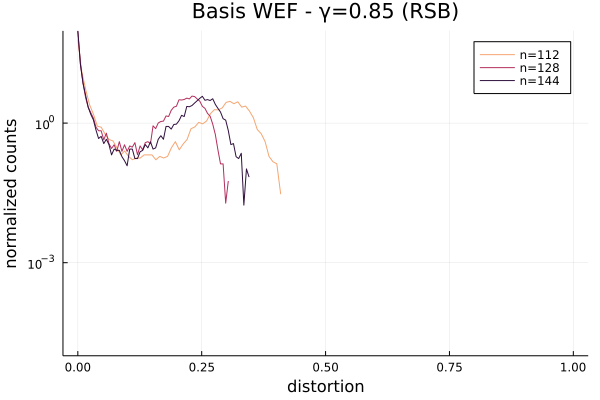

In [457]:
using ColorSchemes
cg = cgrad(:matter, 2*length(ns_rsb), categorical=true)
wef_rsb = plot()
for (i,n) in enumerate(ns_rsb)
    w = merge_wefs(wefs_rsb[i])
    w = sum(wefs_rsb[i])
    plot_wef!(wef_rsb, w, normalize=true, plotmin=false, st=:line, c=cg[2i], label="n=$n")
end
plot!(wef_rsb, title="Basis WEF - γ=$γ_rsb (RSB)", yaxis=(:log10, (1e-5,Inf)))

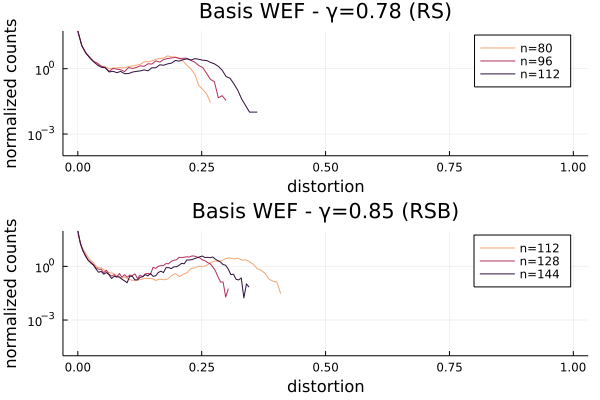

In [357]:
plot(wef_rs, wef_rsb, layout=(2,1), size=(600,400))

In [352]:
savefig("basis_wef.pdf")

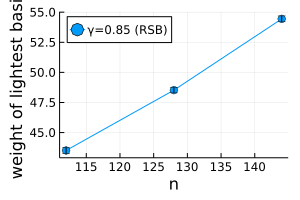

In [339]:
pl_rsb = plot(ns_rsb, mean.(weights_rsb) , err=std.(weights_rsb)./sqrt(nsamples_rsb), label="γ=$γ_rsb (RSB)", m=:o,
    xlabel="n", ylabel="weight of lightest basis", legend=:topleft, size=(300,200))

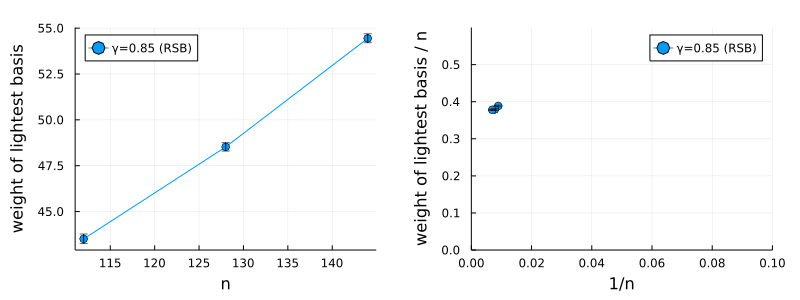

In [340]:
pl_rsb2 = plot(1 ./ns_rsb, mean.(weights_rsb) ./ ns_rsb, label="γ=$γ_rsb (RSB)", m=:o, 
    yerr=std.(weights_rsb)./sqrt(nsamples_rsb)./ ns_rsb,
    xlabel="1/n", ylabel="weight of lightest basis / n", xlims=(0, 0.1), 
    ylims=(0,0.6))
plot(pl_rsb, pl_rsb2, size=(800,300), margin=5Plots.mm)

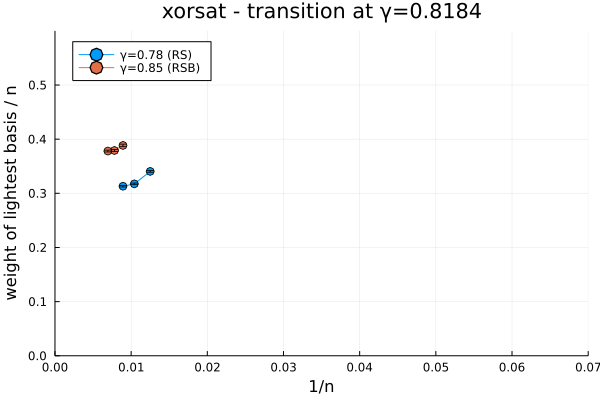

In [341]:
 plot!(deepcopy(pl_rs2), 1 ./ns_rsb, mean.(weights_rsb) ./ ns_rsb, label="γ=$γ_rsb (RSB)", m=:o,
    yerr=std.(weights_rsb)./sqrt(nsamples_rsb)./ ns_rsb,
    xlabel="1/n", ylabel="weight of lightest basis / n", legend=:topleft, xlims=(0, 0.07), dpi=300,
    title="xorsat - transition at γ=0.8184")

Plot a bunch

In [418]:
function plot_wef(ns::AbstractVector{Int}, wefs, nplots=12, ids=rand(1:length(wefs),nplots),
        yaxis=(:log10, (1e-4,Inf)); kw...)
    cg = cgrad(:matter, 2*length(ns), categorical=true)
    pl = Vector{Plots.Plot}(undef, nplots)
    for j in 1:nplots
        pl[j] = plot()
        for (i,n) in enumerate(ns)
            plot_wef!(pl[j], wefs[i][ids[j]], normalize=true, plotmin=false, st=:line, c=cg[2i], label="n=$n", 
                fontsize=6, ylabel="", xlabel="")
        end
    end
    plot(pl..., yaxis=yaxis, layout=(3,4); kw...)
end

plot_wef (generic function with 11 methods)

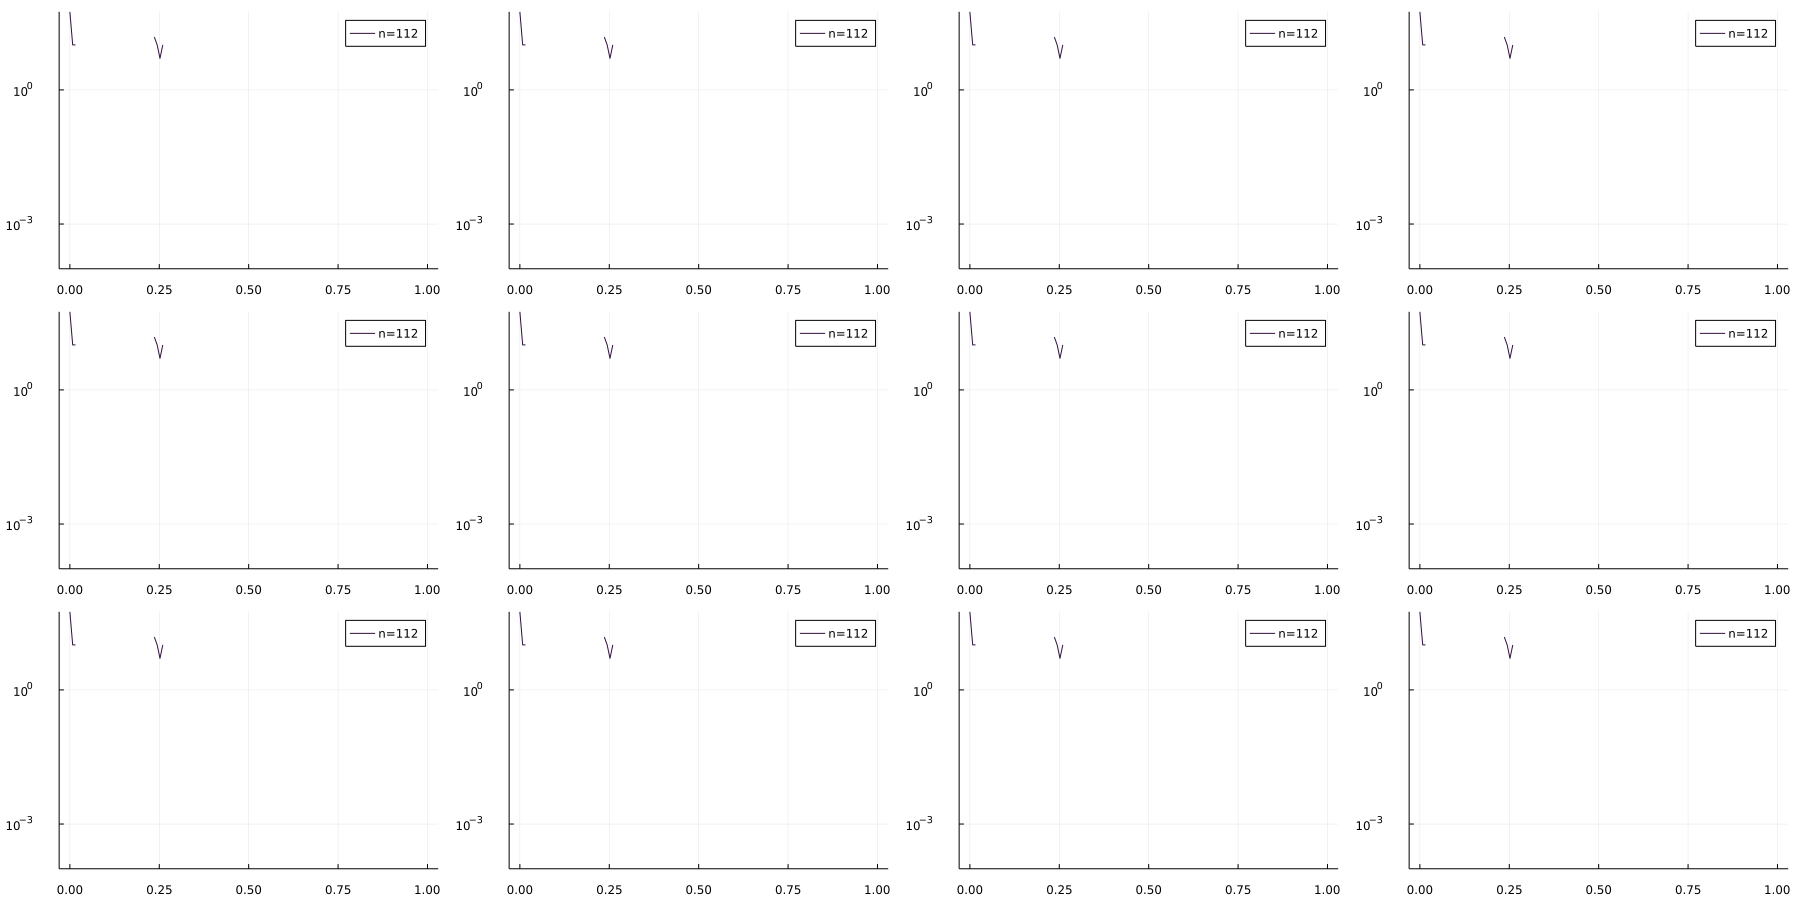

In [433]:
plss = plot_wef([ns_rs[end]], [wefs_rs[end]], size=(900,450).*2)
# plot(plss..., layout=(4,5))

In [434]:
savefig("basis_wef_rs.pdf")

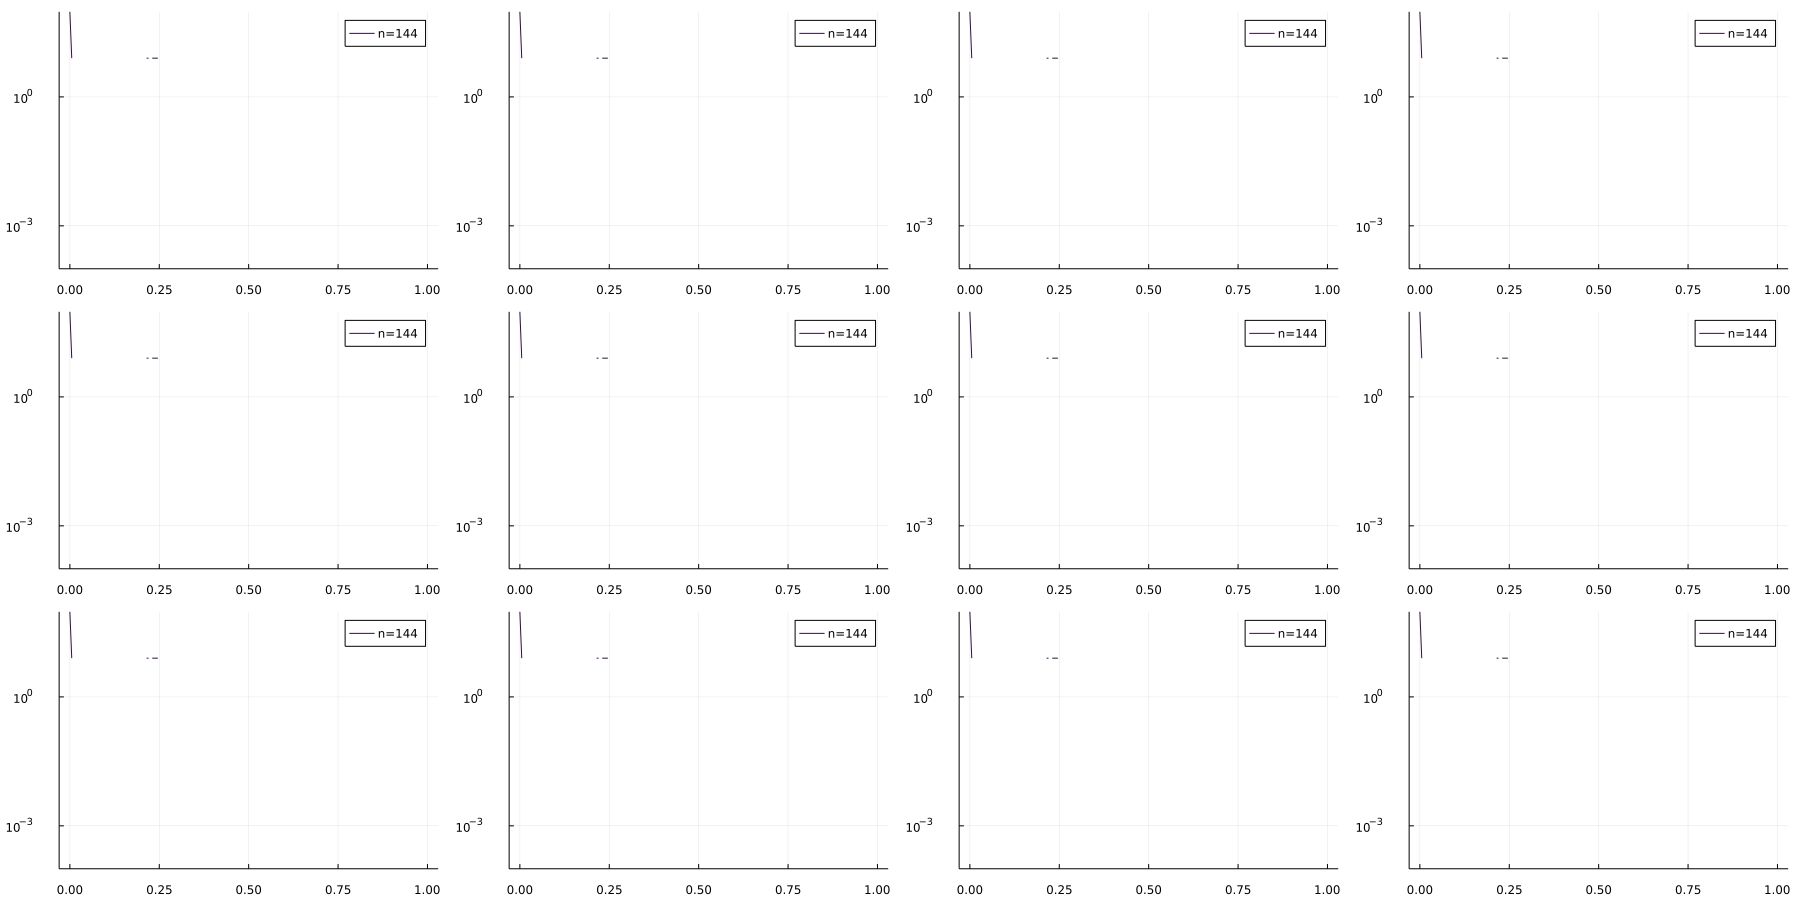

In [435]:
plss = plot_wef([ns_rsb[end]], [wefs_rsb[end]], size=(900,450).*2)

In [436]:
savefig("basis_wef_rsb.pdf")

## Span a range

In [6]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()

22

In [85]:
const p = 3
gammas = 0.76:0.04:0.88
ns = 10 .* [ (2:9), (2:11), (2:12), (2:13) ]
nsamples = 10 * [300, 300, 300, 1000]
@assert length(ns) == length(gammas) == length(nsamples)
weights = [[zeros(Int, nsamples[i]) for _ in ns[i]] for i in eachindex(ns)]
times = zeros(length(ns));

In [ ]:
@telegram "xorsat basis range" for (i,γ) in enumerate(gammas)
    println("### Rate $i of ", length(gammas), ". γ=$γ")
    t = @timed begin
        for (j,n) in enumerate(ns[i]) 
            m = round(Int, n*γ)
            println("Size n=$n. True γ=", m/n)
            @threads for k in 1:nsamples[i]
                H = pspinmatrix(n, m, p)
                B, indep = findbasis_slow(H)
                B = BitMatrix(B)
                BB = augment_basis(B)
                Blight, weights[i][j][k] = lightest_basis(BB, indep, n, showprogress=false)
            end
            flush(stdout)
        end
    end
    times[i] = t.time
end

### Rate 1 of 4. γ=0.76
Size n=20. True γ=0.75
Size n=30. True γ=0.7666666666666667


In [ ]:
using DelimitedFiles
open("lightest_basis_xorsat.txt", "w") do io
    writedlm(io, gammas)
    for (i,γ) in enumerate(gammas)
        writedlm(io, [ns[i] mean.(weights[i]) std.(weights[i])./sqrt(nsamples[i])])
    end
end

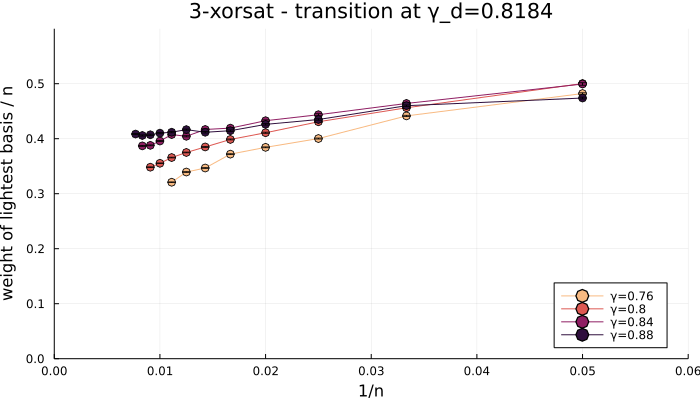

In [90]:
using ColorSchemes
cg = cgrad(:matter, 2*length(gammas), categorical=true)
pl = plot()
for (i,γ) in enumerate(gammas[1:end])
   plot!(pl, 1 ./ns[i], mean.(weights[i]) ./ ns[i], label="γ=$γ", m=:o,
    yerr=std.(weights[i])./sqrt(nsamples[i])./ ns[i], c=cg[2i], 
    xlabel="1/n", ylabel="weight of lightest basis / n", dpi=300,
    title="3-xorsat - transition at γ_d=0.8184") 
end
plot(pl, ylims=(0,0.6), xlims=(0, 0.06), size=(700,400), legend=:bottomright)

In [91]:
times ./ 60

4-element Vector{Float64}:
 303.29568289823334
 331.8608216691666
  57.04846665996667
  36.70740267588334